# Inverse design of bimaterial LCE lattice: programmable aspect ratios


## Imports

In [1]:
from morphing_lattices.optimization import ForwardProblem, OptimizationProblem, scale_points, shift_points
from morphing_lattices.structure import Lattice, ControlParams
from morphing_lattices.geometry import triangular_lattice_points, triangular_lattice_connectivity
from morphing_lattices.plotting import plot_lattice, generate_animation
import pandas as pd
import jax.numpy as jnp
import pickle
import os
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import experimental material params


In [2]:
exp_actuation_strain = pd.read_csv(
    '../../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv'
).drop(['Unnamed: 3'], axis=1)
exp_modulus_fine = pd.read_csv(
    '../../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv'
)
exp_modulus_fine.columns = [
    'Temp',
    'LTNI_avg_young',
    'LTNI_stdev',
    'HTNI_avg_young',
    'HTNI_stdev',
]
exp_modulus_fine.drop([0, 1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG HTNI', 'STD HTNI']
].astype(float)
LTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG LTNI', 'STD LTNI']
].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'HTNI_avg_young']
].astype(float)
LTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'LTNI_avg_young']
].astype(float)


def HTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))


def LTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))


def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

## Optimization problem

### Temperature evolution

In [3]:
sampled_temperatures = jnp.array([
    22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130
])

simulation_time = 9000.  # s
sampled_times = jnp.linspace(0, simulation_time, sampled_temperatures.shape[0])


def temperature_fn(t):
    return jnp.interp(t, sampled_times, sampled_temperatures)


def young_1_fn(t):
    return HTNI_young_fit_fine(temperature_fn(t))


def young_2_fn(t):
    return LTNI_young_fit_fine(temperature_fn(t))


def thermal_strain_1_fn(t):
    return (HTNI_stretch(temperature_fn(t))-1.)*0.8


def thermal_strain_2_fn(t):
    return (LTNI_stretch(temperature_fn(t))-1.)*0.7

### Forward problem

(<Figure size 1000x500 with 1 Axes>, <Axes: title={'center': 'Lattice'}>)

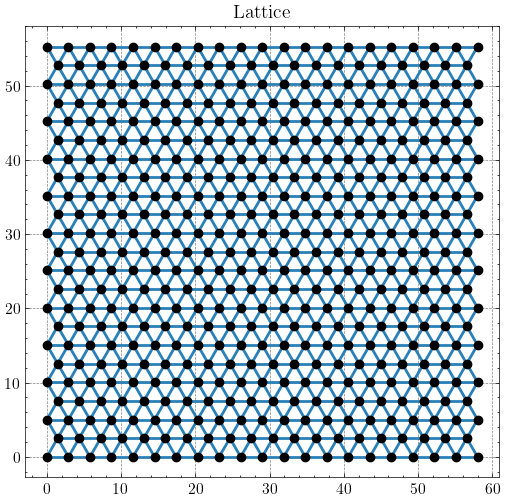

In [4]:
n1 = 20
n2 = 22
spacing = 2.9  # mm
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(
    n1=n1,
    n2=n2
)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]
n_timepoints = sampled_temperatures.shape[0]

control_params = ControlParams(
    reference_points=points,  # mm
    young=jnp.ones(n_bonds),  # MPa
    area=jnp.ones(n_bonds)*(4*0.125**2),  # mm^2
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
    # NOTE: This is the initial guess for the material distribution
    phase=0.5*jnp.ones(n_bonds),#jnp.linspace(0, 1, n_bonds),  # NOTE: 0 means HTNI, 1 means LTNI
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
problem = ForwardProblem(
    lattice=lattice,
    simulation_time=simulation_time,
    n_timepoints=n_timepoints,
)
problem.setup(
    young_1_fn=young_1_fn,
    young_2_fn=young_2_fn,
    thermal_strain_1_fn=thermal_strain_1_fn,
    thermal_strain_2_fn=thermal_strain_2_fn,
    temperature_fn = temperature_fn,
)
plot_lattice(lattice=lattice, figsize=(10, 5))

### Target Points

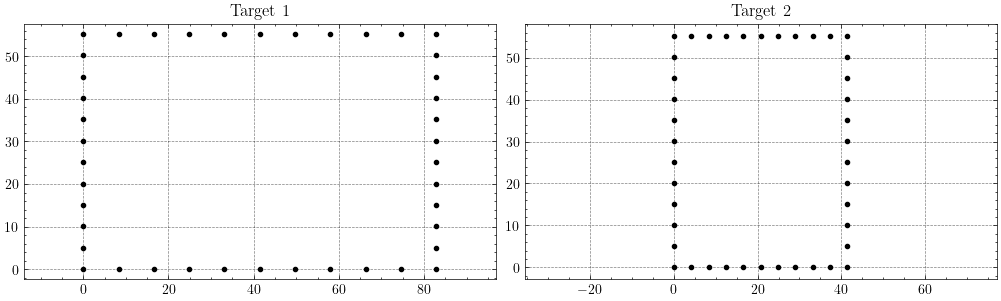

In [5]:
# Select nodes on the boundary
bottom_edge_ids = jnp.arange(0, n1)[::2]
right_edge_ids = jnp.arange(n1, n_points-1, 2*n1+1)
top_edge_ids = jnp.arange(n_points-n1, n_points, 1)[::-1][::2]
left_edge_ids = jnp.arange(2*n1+1, n_points, 2*n1+1)[::-1]
target_points_ids = jnp.concatenate([
    bottom_edge_ids,
    right_edge_ids,
    top_edge_ids,
    left_edge_ids,
])
target_ref_points = lattice.control_params.reference_points[target_points_ids]

# Define aspect ratios as alpha = width/height
aspect_ratio_1 = 1.5
aspect_ratio_2 = 0.75

optimization_name = f"n1_{n1}_n2_{n2}_a1_{aspect_ratio_1:.2f}_a2_{aspect_ratio_2:.2f}"

target1_points = target_ref_points*jnp.array([aspect_ratio_1*jnp.max(target_ref_points[:, 1])/jnp.max(target_ref_points[:, 0]), 1]).T
target2_points = target_ref_points*jnp.array([aspect_ratio_2*jnp.max(target_ref_points[:, 1])/jnp.max(target_ref_points[:, 0]), 1]).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
ax1.plot(target1_points[:, 0], target1_points[:, 1],
         'o', color='k', markersize=3)
ax2.plot(target2_points[:, 0], target2_points[:, 1],
         'o', color='k', markersize=3)
ax1.set_title('Target 1')
ax2.set_title('Target 2')
ax1.axis('equal')
ax2.axis('equal')

save_opt_information = True
if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shapes.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

### Optimization


### Run optimization


In [6]:
target1_temperature = 70. # Celcius
target2_temperature = 130. # Celcius

optimization = OptimizationProblem(
    forward_problem=problem,
    target1_points=target1_points,
    target2_points=target2_points,
    target_points_ids=target_points_ids,
    target1_temperature=target1_temperature,
    target2_temperature=target2_temperature,
)

In [7]:
optimization.run_optimization_nlopt(
    n_iterations=50,
    # max_time=60,
    lower_bound=0.,
    upper_bound=1.,
)

Iteration: 1
Objective = 0.2594569877407979
Iteration: 2
Objective = 0.25917779482162706
Iteration: 3
Objective = 0.2565593244905693
Iteration: 4
Objective = 0.23123355588660321
Iteration: 5
Objective = 0.1557820158941205
Iteration: 6
Objective = 0.25760576031303234
Iteration: 7
Objective = 0.19333431986526478
Iteration: 8
Objective = 0.1624724637787789
Iteration: 9
Objective = 0.14853966959872922
Iteration: 10
Objective = 0.14425079242294048
Iteration: 11
Objective = 0.12938669414248669
Iteration: 12
Objective = 0.16532096385112005
Iteration: 13
Objective = 0.12637915889440376
Iteration: 14
Objective = 0.10045650271947346
Iteration: 15
Objective = 0.11577919118875135
Iteration: 16
Objective = 0.09103922213402615
Iteration: 17
Objective = 0.09265476679951239
Iteration: 18
Objective = 0.08218829626048829
Iteration: 19
Objective = 0.07740194858036535
Iteration: 20
Objective = 0.11458360933377162
Iteration: 21
Objective = 0.06653183268759527
Iteration: 22
Objective = 0.061863302657564886


In [8]:
dir_path = f"{optimization_name}"
out_path = Path(f"{str(dir_path)}/optimization_data.pickle")
out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist

optimization_data = optimization.to_data()

with open(out_path, 'wb') as f:
    pickle.dump(optimization_data, f)

### Plot the objective values

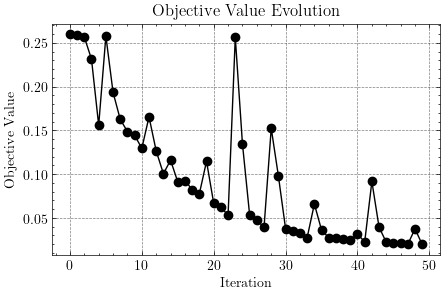

In [9]:
plt.figure(figsize=[5,3])
plt.plot(optimization.objective_values, color='k', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value Evolution');

if save_opt_information:
    out_path = Path(f"{optimization_name}/objective_value_evolution.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/objective_value_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

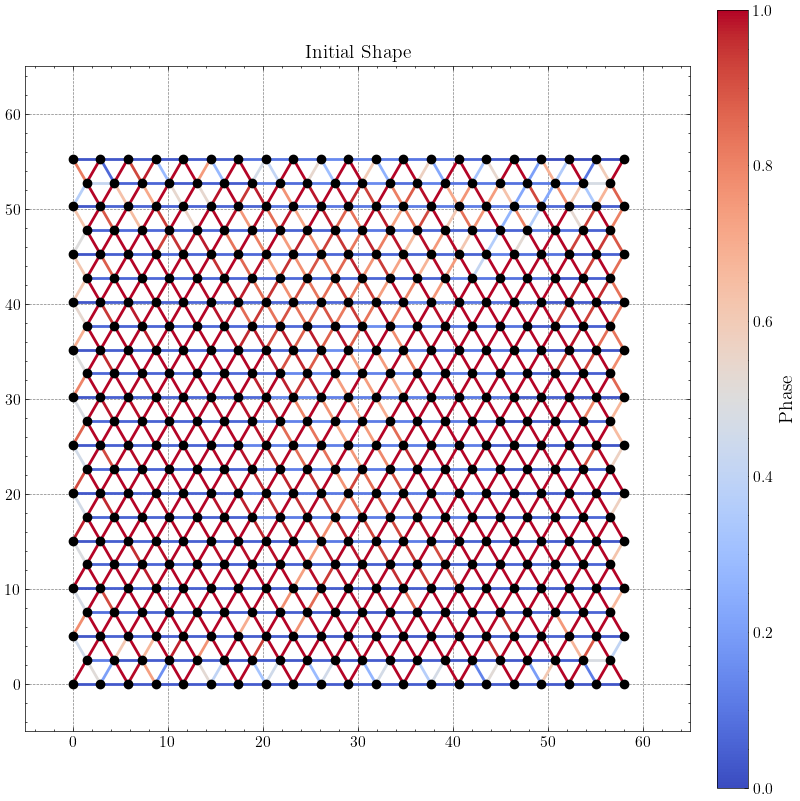

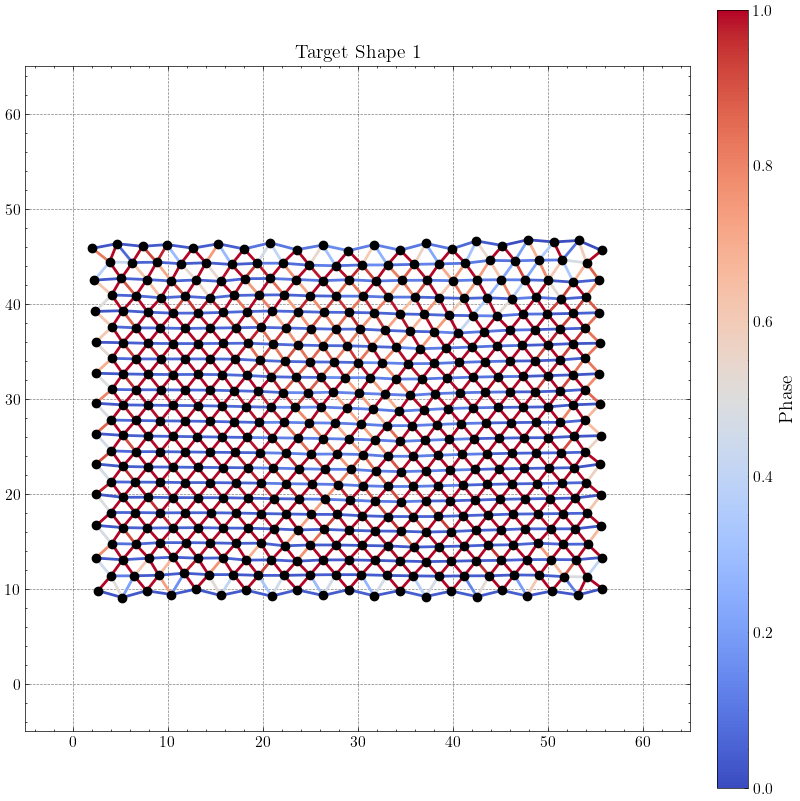

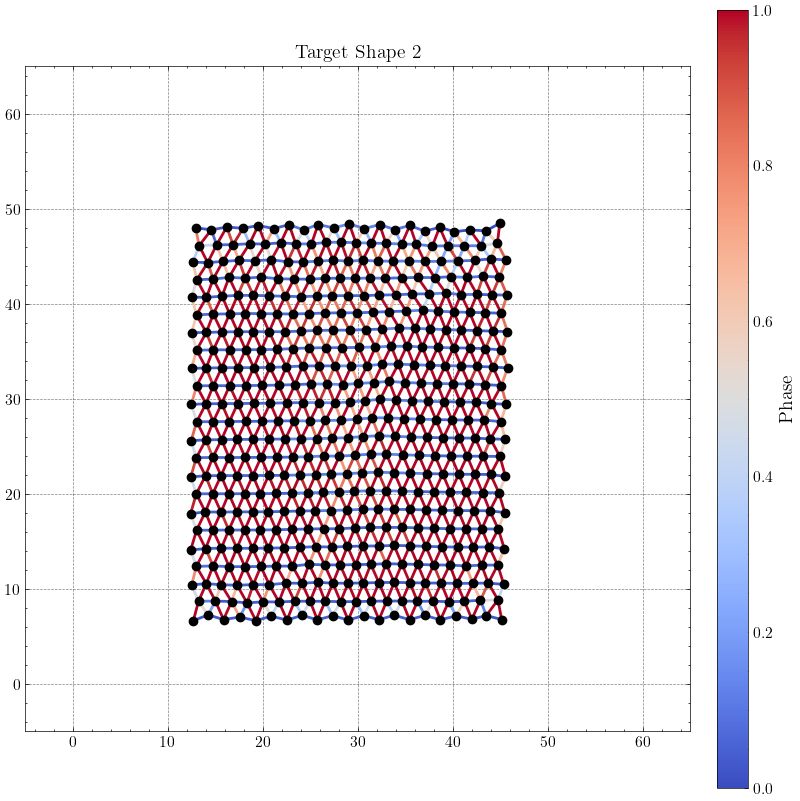

In [10]:
plot_lattice(
    lattice=lattice,
    title='Initial Shape',
    displacement=optimization.best_response[0, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/initial_shape_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/initial_shape_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=optimization.best_response[optimization.target1_temperature_timepoint, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/target_shape1_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=optimization.best_response[optimization.target2_temperature_timepoint, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    legend_label="Phase",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/target_shape2_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

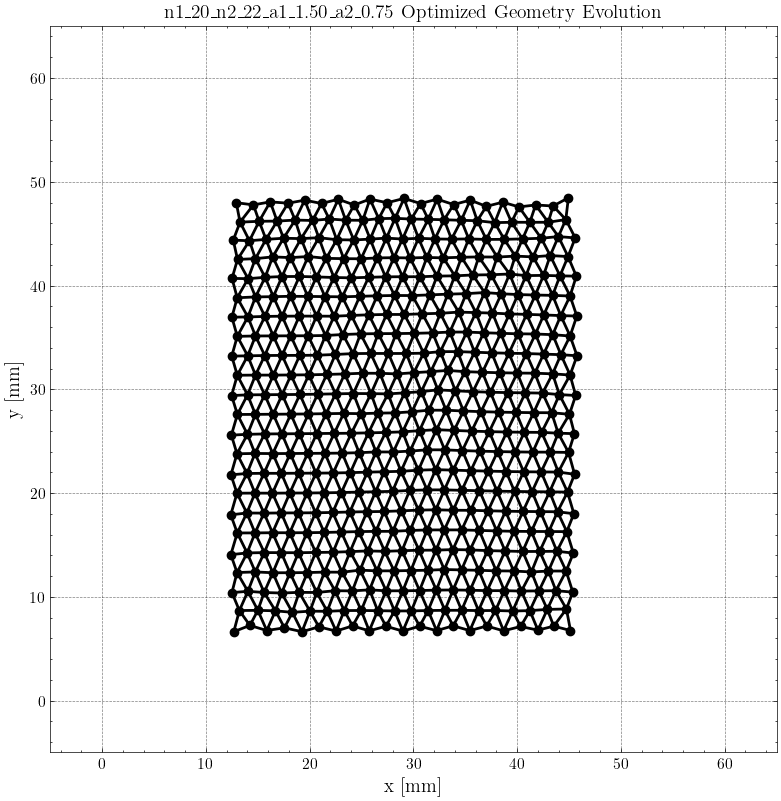

In [11]:
generate_animation(
    lattice=lattice, 
    solution=optimization.best_response, 
    out_filename=f'{optimization_name}/animation', 
    frame_range=jnp.arange(23), 
    xlim=[-5, 65],
    ylim=[-5, 65],
    figsize=[8, 8], 
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Optimized Geometry Evolution')

### Impose Discrete Phase Values Corresponding to HTNI and LTNI LCE

In [12]:
phase_threshold = 0.5
discrete_phases = jnp.where(optimization.best_control_params.phase > phase_threshold, 1, 0)

discrete_phase_solution, discrete_control_params = problem.solve(discrete_phases)

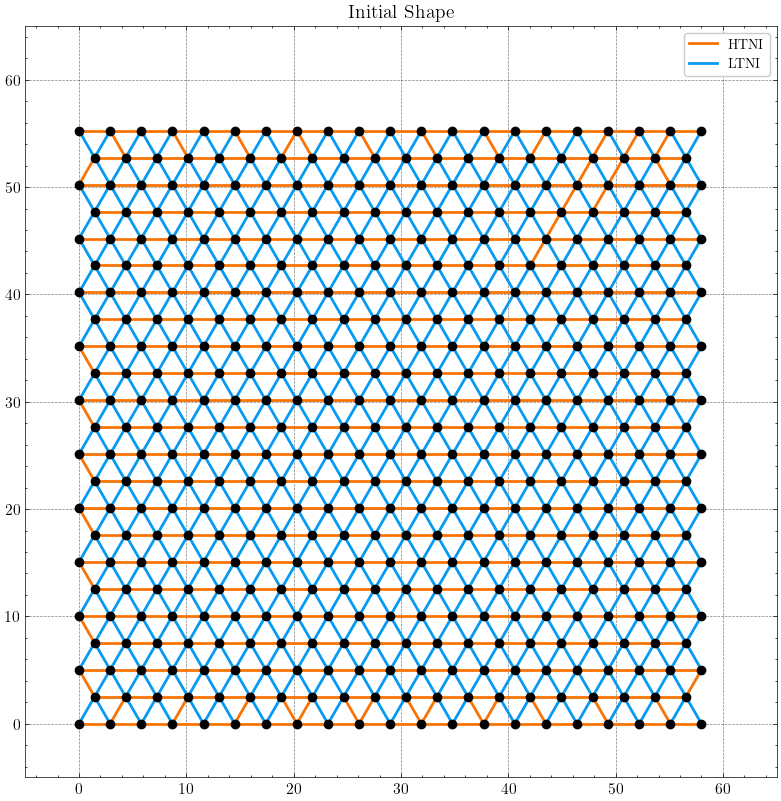

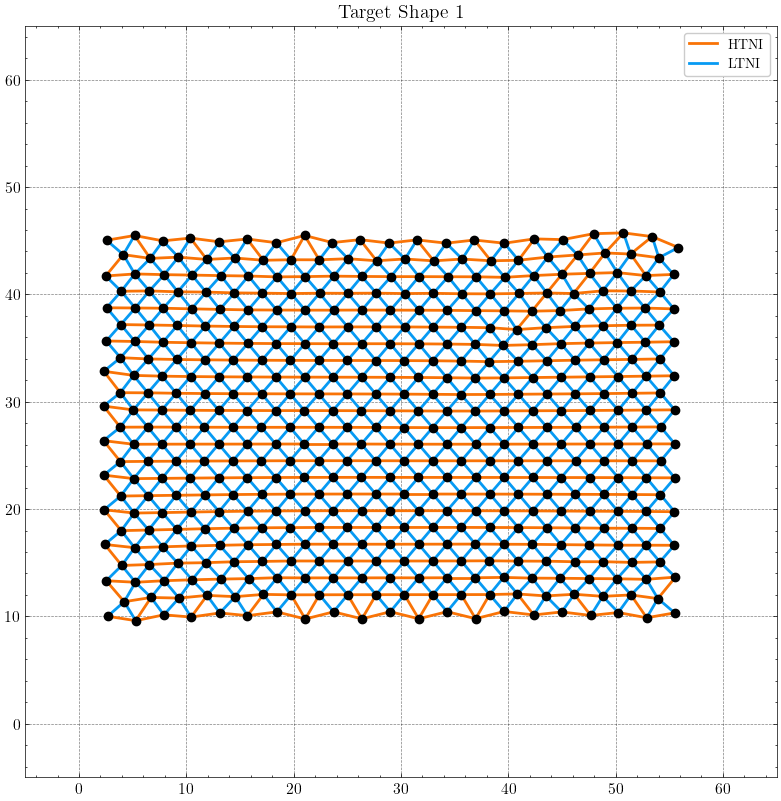

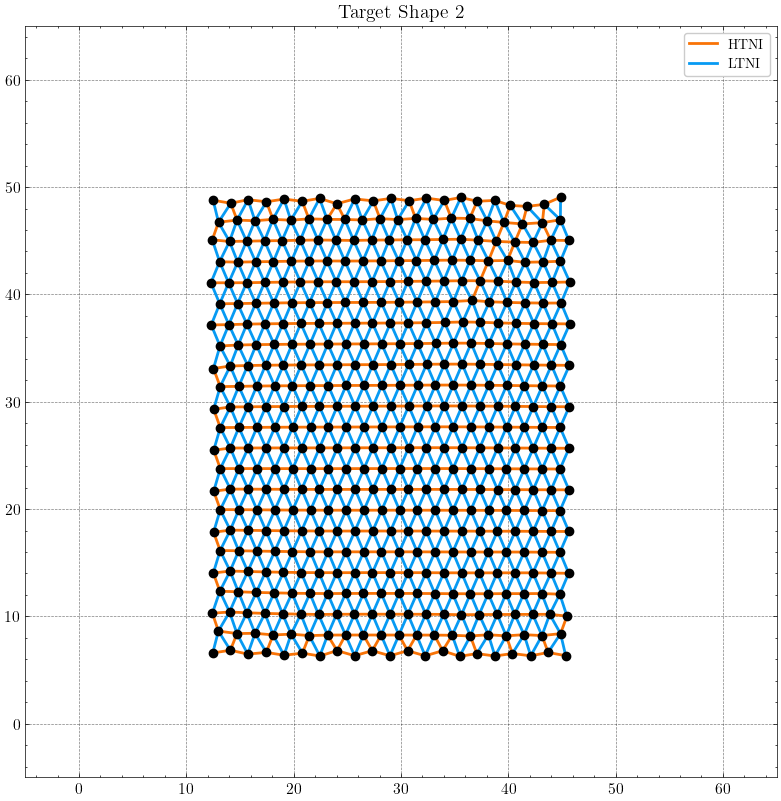

In [13]:
LTNI_bond_indices = jnp.where(discrete_phases == 1)[0]
HTNI_bond_indices = jnp.where(discrete_phases == 0)[0]

plot_lattice(
    lattice=lattice,
    title='Initial Shape',
    displacement=discrete_phase_solution[0, 0],
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_initial_shape_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/LCE_labeled_initial_shape_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=discrete_phase_solution[optimization.target1_temperature_timepoint, 0],
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape1_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/LCE_labeled_target_shape1_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=discrete_phase_solution[optimization.target2_temperature_timepoint, 0],
    figsize=(8, 8),
    xlim=(-5, 65),
    ylim=(-5, 65),
    HTNI_bond_indices=HTNI_bond_indices,
    LTNI_bond_indices=LTNI_bond_indices,
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/LCE_labeled_target_shape2_phase_vals.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/LCE_labeled_target_shape2_phase_vals.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

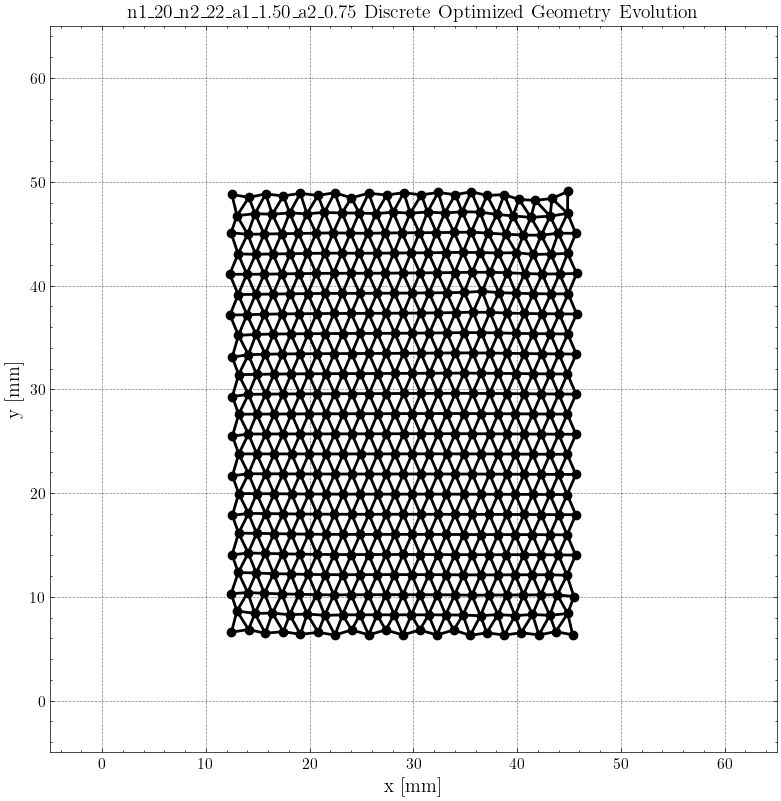

In [14]:
generate_animation(
    lattice=lattice, 
    solution=discrete_phase_solution, 
    out_filename=f'{optimization_name}/discrete_animation', 
    frame_range=jnp.arange(n_timepoints), 
    xlim=[-5, 65],
    ylim=[-5, 65],
    figsize=[8, 8],  
    x_label='x [mm]',
    y_label='y [mm]',
    title=f'{optimization_name} Discrete Optimized Geometry Evolution')

### Final Response vs Target Points

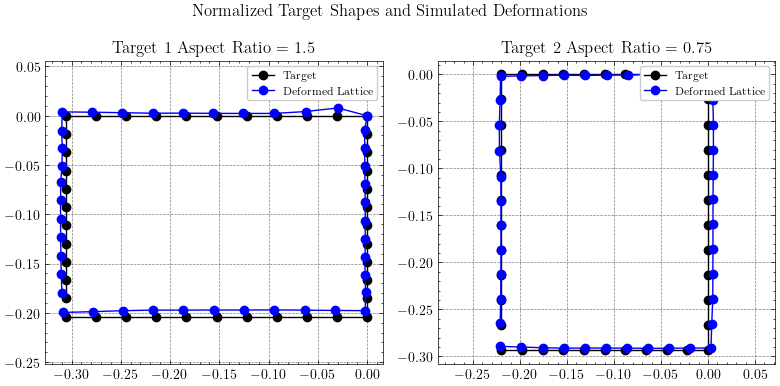

In [15]:
deformed_target1_points = discrete_phase_solution[optimization.target1_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]
deformed_target2_points = discrete_phase_solution[optimization.target2_temperature_timepoint, 0][target_points_ids]+optimization.best_control_params.reference_points[target_points_ids]

# Scale and shift target1_points, target2_points, and the deformed lattice points
transformed_deformed_target1_points = shift_points(scale_points(deformed_target1_points))
transformed_deformed_target2_points = shift_points(scale_points(deformed_target2_points))

transformed_target1_points = shift_points(scale_points(target1_points))
transformed_target2_points = shift_points(scale_points(target2_points))


# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,4])
ax1.plot(transformed_target1_points[:, 0], transformed_target1_points[:, 1], 'ko-', label='Target')
ax1.plot(transformed_deformed_target1_points[:, 0], transformed_deformed_target1_points[:, 1], 'bo-', label='Deformed Lattice')
ax1.legend(fontsize=8, loc='upper right')
ax1.set_title(f'Target 1 Aspect Ratio = {aspect_ratio_1}')

ax2.plot(transformed_target2_points[:, 0], transformed_target2_points[:, 1], 'ko-', label='Target')
ax2.plot(transformed_deformed_target2_points[:, 0], transformed_deformed_target2_points[:, 1], 'bo-', label='Deformed Lattice')
ax2.legend(fontsize=8, loc='upper right')
ax2.set_title(f'Target 2 Aspect Ratio = {aspect_ratio_2}')

ax1.axis('equal')
ax2.axis('equal')

plt.suptitle('Normalized Target Shapes and Simulated Deformations')
plt.tight_layout()

if save_opt_information:
    out_path = Path(f"{optimization_name}/normalized_target_and_deformed_shapes.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path), dpi=200)

    out_path_svg = Path(f"{optimization_name}/normalized_target_and_deformed_shapes.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)